# Adversarial Robustness of CNNs: Defenses against PGD Attacks 

### Jakub Binkowski 151921
### Benedykt Huszcza 151313

### Model architecture

In [30]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt

import foolbox as fb
from foolbox.attacks import *
from scipy.ndimage import gaussian_filter
from sklearn.model_selection import KFold
from torch.utils.data import Subset
from sklearn.metrics import accuracy_score


def plot_images(original, adversarial, defence):
    background_rgb = (246/255, 246/255, 245/255)

    original = original.cpu().permute(1, 2, 0).numpy()
    adversarial = adversarial.cpu().permute(1, 2, 0).numpy()
    defence = defence.cpu().permute(1, 2, 0).numpy()
    
    fig = plt.figure(figsize=(8, 4), facecolor=background_rgb)

    plt.subplot(1, 3, 1)
    plt.title("Original image")
    plt.imshow(original)
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.title("Image after attack PGD")
    plt.imshow(adversarial)
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.title("Image after defence")
    plt.imshow(defence)
    plt.axis('off')

    plt.tight_layout()
    plt.show()



class SimpleCIFARCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),  

            nn.Conv2d(64, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2), 

            nn.Conv2d(128, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((1, 1))  
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, 10)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x




transform = transforms.Compose([
    transforms.ToTensor()
])

dataset = torchvision.datasets.CIFAR10(root='./data', train=True, transform=transform, download=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
batch_size = 64





Files already downloaded and verified


### Model evaluation and cross validation

In [ ]:
k_folds = 5
num_epochs = 12

kfold = KFold(n_splits=k_folds, shuffle=True, random_state=42)
fold_accuracies = []

for fold, (train_idx, val_idx) in enumerate(kfold.split(dataset)):
    print(f"\n====== Fold {fold+1} ======")

    train_subset = Subset(dataset, train_idx)
    val_subset = Subset(dataset, val_idx)

    train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False)

    model = SimpleCIFARCNN().to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


kfold = KFold(n_splits=k_folds, shuffle=True, random_state=42)
fold_accuracies = []

for fold, (train_idx, val_idx) in enumerate(kfold.split(dataset)):
    print(f"\n====== Fold {fold+1} ======")

    train_subset = Subset(dataset, train_idx)
    val_subset = Subset(dataset, val_idx)

    train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False)

    model = SimpleCIFARCNN().to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    best_acc = 0.0
    patience = 3
    patience_counter = 0
    epoch = 0

    while patience_counter < patience:
        epoch += 1
        model.train()
        total_loss = 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        model.eval()
        all_preds = []
        all_labels = []
        with torch.no_grad():
            for images, labels in val_loader:
                images = images.to(device)
                outputs = model(images)
                preds = outputs.argmax(dim=1).cpu().numpy()
                all_preds.extend(preds)
                all_labels.extend(labels.numpy())
        acc = accuracy_score(all_labels, all_preds)

        print(f"Epoch {epoch}, loss: {total_loss:.4f}, validation accuracy: {acc:.4f}")

        if acc > best_acc:
            best_acc = acc
            patience_counter = 0
        else:
            patience_counter += 1
            print(f"No improvement ({patience_counter}/{patience})")

    fold_accuracies.append(best_acc)
    print(f"Best accuracy for fold {fold+1}: {best_acc:.4f}")

print("\n====== Summary cross-validation ======")
for i, acc in enumerate(fold_accuracies):
    print(f"Fold {i+1}: Accuracy = {acc:.4f}")
print(f"Średnia accuracy: {np.mean(fold_accuracies):.4f}")


### Final model training

In [ ]:
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, transform=transform, download=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

train_loader_full = DataLoader(dataset, batch_size=batch_size, shuffle=True)

final_model = SimpleCIFARCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(final_model.parameters(), lr=0.001)

num_epochs_final = 15
final_model.train()
for epoch in range(num_epochs_final):
    total_loss = 0
    for images, labels in train_loader_full:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = final_model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"[FINAL] Epoch {epoch+1}/{num_epochs_final}, loss: {total_loss:.4f}")

final_model.eval()
all_preds = []
all_labels = []
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = final_model(images)
        preds = outputs.argmax(dim=1).cpu().numpy()
        all_preds.extend(preds)
        all_labels.extend(labels.numpy())

test_acc = accuracy_score(all_labels, all_preds)
print(f"\nFinal accuracy on the test set: {test_acc:.4f}")


### Example of attack and defence for one image

Is the attack efficient?: True
Original prediction: 5
Prediction after attack: 7
Prediction after Gaussian blur: 5


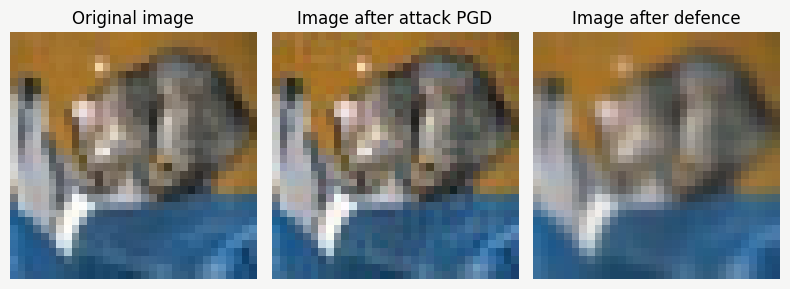

In [48]:
import cv2

final_model.eval()

fmodel = fb.PyTorchModel(final_model, bounds=(0, 1))

images, labels = next(iter(test_loader))
image = images[0:1].to(device)  
label = labels[0:1].to(device)   


attack = PGD()
raw, clipped, is_adv = attack(fmodel, image, label, epsilons=0.02)

print("Is the attack efficient?:", is_adv.item())
original_pred = fmodel(image).argmax(dim=1).item()

adv_pred = fmodel(clipped).argmax(dim=1).item()
print("Original prediction:", original_pred)
print("Prediction after attack:", adv_pred)


img_np = clipped[0].detach().cpu().numpy().transpose(1, 2, 0)
blurred_np = cv2.GaussianBlur(img_np, (3, 3), sigmaX=0.7)
blurred_np = blurred_np.transpose(2, 0, 1)
blurred_tensor = torch.tensor(blurred_np, dtype=torch.float32).unsqueeze(0).to(device)

blurred_pred = fmodel(blurred_tensor).argmax(dim=1).item()
print("Prediction after Gaussian blur:", blurred_pred)
plot_images(images[0], clipped[0], blurred_tensor[0])


### Example of mixing multiple attacks and defences for one image

In [19]:
import torch
import numpy as np
from scipy.ndimage import gaussian_filter
import foolbox as fb
from foolbox.attacks import (
    LinfFastGradientAttack,
    L2ProjectedGradientDescentAttack,
    L2DeepFoolAttack,
    L2CarliniWagnerAttack
)

import torchvision
from torchvision.transforms import ToTensor, ToPILImage
import torchvision.transforms.functional as TF
from torch.utils.data import DataLoader
from PIL import Image, ImageFilter
import io


sigma_range = np.linspace(0.01, 1.0, 20)  

bilateral_params = [
    (5, 30, 30),
    (7, 50, 50),
    (9, 75, 75),
    (11, 100, 100),
]


def gaussian_defense(img, sigma):
    np_img = img[0].detach().cpu().numpy()
    blurred = gaussian_filter(np_img, sigma=sigma)
    return torch.tensor(blurred, dtype=torch.float32).unsqueeze(0).to(device)

def multi_blur(img, sigma):
    sigmas = [sigma/2, sigma, sigma*1.5]
    blurred_imgs = [gaussian_filter(img[0].detach().cpu().numpy(), s) for s in sigmas]
    avg_blur = np.mean(blurred_imgs, axis=0)
    return torch.tensor(avg_blur, dtype=torch.float32).unsqueeze(0).to(device)

def median_filter(img, kernel_size):
    pil = ToPILImage()(img[0].cpu()).convert("RGB")
    filtered = pil.filter(ImageFilter.MedianFilter(size=int(kernel_size)))
    return ToTensor()(filtered).unsqueeze(0).to(device)

def jpeg_compression(img, quality):
    pil = ToPILImage()(img[0].cpu())
    buffer = io.BytesIO()
    pil.save(buffer, format='JPEG', quality=int(quality))
    compressed = Image.open(buffer)
    return ToTensor()(compressed).unsqueeze(0).to(device)


def bilateral_filter(img, d_sigma):
    """Bilateral filter — d_sigma to tuple (d, sigmaColor, sigmaSpace)"""
    d, sigma_color, sigma_space = d_sigma
    img_np = img[0].detach().cpu().numpy().transpose(1, 2, 0)  
    img_np = (img_np * 255).astype(np.uint8)  
    filtered = cv2.bilateralFilter(img_np, d=int(d), sigmaColor=sigma_color, sigmaSpace=sigma_space)
    filtered = filtered.astype(np.float32) / 255.0
    filtered = filtered.transpose(2, 0, 1)  
    return torch.tensor(filtered).unsqueeze(0).to(device)


defenses = [
    ("Gaussian Blur", gaussian_defense, sigma_range),
    ("Multi Gaussian", multi_blur, sigma_range),
    ("Median Filter", median_filter, np.array([1, 3, 5, 7])),
    ("JPEG Compression", jpeg_compression, np.linspace(10, 100, 10)),
    ("Bilateral Filter", bilateral_filter, bilateral_params)
]


def run_attack(fmodel, image, label, attack, epsilons=np.linspace(0.01, 0.9, 20)):
    image = image.to(device).unsqueeze(0)
    label = torch.tensor([label.item()], device=device)
    for eps in epsilons:
        try:
            _, adv, is_adv = attack(fmodel, image, label, epsilons=eps)
        except Exception:
            continue
        if is_adv[0].item():
            return adv
    return None

fmodel = fb.PyTorchModel(final_model, bounds=(0, 1), device=device)

images, labels = next(iter(test_loader))
images, labels = images.to(device), labels.to(device)

attacks = [
    (LinfFastGradientAttack(), "FGSM (L-inf)"),
    (L2ProjectedGradientDescentAttack(), "PGD (L2)"),
    (L2DeepFoolAttack(), "DeepFool (L2)"),
    (L2CarliniWagnerAttack(steps=5), "Carlini-Wagner (L2)")
]

for attack, attack_name in attacks:
    print(f"\n===== ATAK: {attack_name} =====")
    adversarial = run_attack(fmodel, images[0], labels[0], attack)
    if adversarial is None:
        print("Adversarial attack failed or did not generate an adversarial example.")
        continue

    original_pred = fmodel(images[0].unsqueeze(0)).argmax(dim=1).item()
    adv_pred = fmodel(adversarial).argmax(dim=1).item()
    print(f"Original prediction: {original_pred}, Adversarial prediction: {adv_pred}")

    for defense_name, defense_fn, param_range in defenses:
        for param in param_range:
            defended = defense_fn(adversarial, param)
            new_pred = fmodel(defended).argmax(dim=1).item()
            if new_pred == original_pred:
                print(f"  ✅ Defence: {defense_name} with param={param} → pred: {new_pred}")
                break
        else:
            print(f"  ⛔ Defence {defense_name} did NOT succeed.")


===== ATAK: FGSM (L-inf) =====
Original prediction: 5, Adversarial prediction: 5
  ✅ Defence: Gaussian Blur with param=0.01 → pred: 5
  ✅ Defence: Multi Gaussian with param=0.01 → pred: 5
  ✅ Defence: Median Filter with param=1 → pred: 5
  ✅ Defence: JPEG Compression with param=10.0 → pred: 5
  ✅ Defence: Bilateral Filter with param=(5, 30, 30) → pred: 5

===== ATAK: PGD (L2) =====
Original prediction: 5, Adversarial prediction: 5
  ✅ Defence: Gaussian Blur with param=0.01 → pred: 5
  ✅ Defence: Multi Gaussian with param=0.01 → pred: 5
  ✅ Defence: Median Filter with param=1 → pred: 5
  ✅ Defence: JPEG Compression with param=10.0 → pred: 5
  ✅ Defence: Bilateral Filter with param=(5, 30, 30) → pred: 5

===== ATAK: DeepFool (L2) =====
Original prediction: 5, Adversarial prediction: 5
  ✅ Defence: Gaussian Blur with param=0.01 → pred: 5
  ✅ Defence: Multi Gaussian with param=0.01 → pred: 5
  ✅ Defence: Median Filter with param=1 → pred: 5
  ✅ Defence: JPEG Compression with param=10.0 → 

### Experiment for multiple images from test set and results

In [22]:
from collections import defaultdict
import pandas as pd

successful_params = defaultdict(list)
failed_params = defaultdict(list)

metrics_df = pd.DataFrame(
    0,
    index=[name for _, name in attacks],
    columns=[name for name, _, _ in defenses]
)

test_iter = iter(test_loader)
for i in range(100):
    images, labels = next(test_iter)
    images, labels = images.to(device), labels.to(device)

    for attack, attack_name in attacks:
        adversarial = run_attack(fmodel, images[0], labels[0], attack)

        if adversarial is None:
            continue  

        original_pred = fmodel(images[0].unsqueeze(0)).argmax(dim=1).item()
        adv_pred = fmodel(adversarial).argmax(dim=1).item()

        for defense_name, defense_fn, param_range in defenses:
            success = False
            for param in param_range:
                defended = defense_fn(adversarial, param)
                new_pred = fmodel(defended).argmax(dim=1).item()
                if new_pred == original_pred:
                    metrics_df.loc[attack_name, defense_name] += 1
                    successful_params[(attack_name, defense_name)].append(param)
                    success = True
                    break
            if not success:
                failed_params[(attack_name, defense_name)].extend(param_range)

### Results visualization

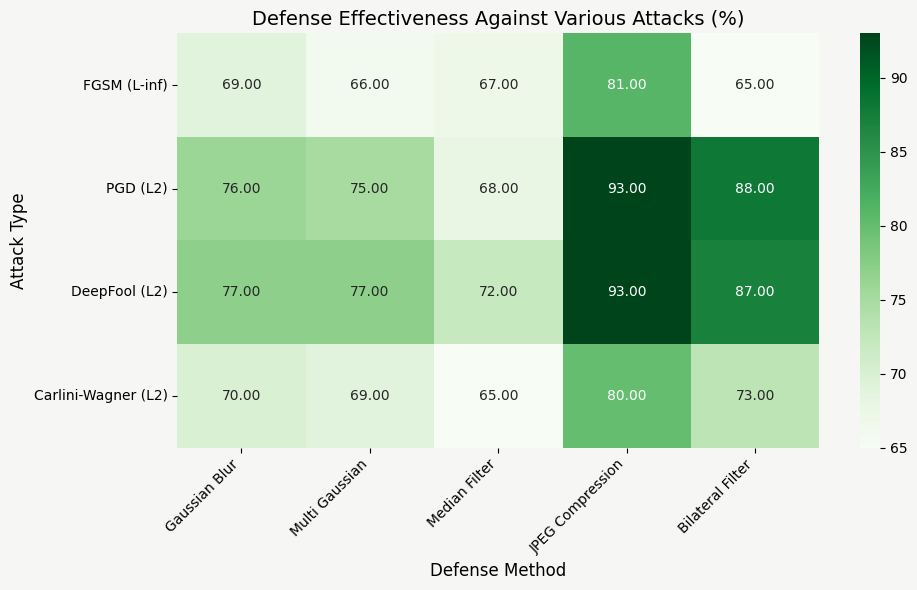

In [32]:
import seaborn as sns
import matplotlib.pyplot as plt

background_rgb = (246/255, 246/255, 245/255)

fig = plt.figure(figsize=(10, 6), facecolor=background_rgb)
ax = sns.heatmap(metrics_df, annot=True, fmt=".2f", cmap="Greens", cbar=True)

ax.set_facecolor(background_rgb)

plt.title("Defense Effectiveness Against Various Attacks (%)", fontsize=14)
plt.xlabel("Defense Method", fontsize=12)
plt.ylabel("Attack Type", fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


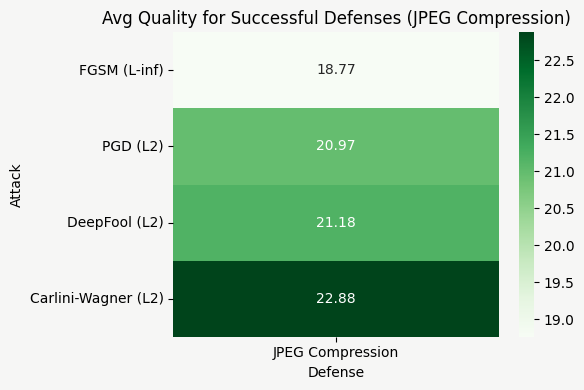

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def build_single_defense_matrix(param_dict, attacks, defense_name_filter):
    data = {}
    for (attack_name, defense_name), params in param_dict.items():
        if defense_name == defense_name_filter and params:
            try:
                float_params = [float(p) for p in params]
                avg = sum(float_params) / len(float_params)
                data[attack_name] = avg
            except:
                pass
    return pd.DataFrame.from_dict(data, orient='index', columns=[defense_name_filter])

selected_defense = "JPEG Compression"

jpeg_success = build_single_defense_matrix(successful_params, attacks, selected_defense)
jpeg_fail = build_single_defense_matrix(failed_params, attacks, selected_defense)

background_rgb = (246/255, 246/255, 245/255)

fig = plt.figure(figsize=(6, 4), facecolor=background_rgb)
ax = fig.add_subplot(111)
sns.heatmap(jpeg_success, annot=True, fmt=".2f", cmap="Greens", cbar=True, ax=ax)

ax.set_title(f"Avg Quality for Successful Defenses ({selected_defense})")
ax.set_xlabel("Defense")
ax.set_ylabel("Attack")

ax.set_facecolor(background_rgb)

plt.tight_layout()
plt.show()
